In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import cycle

In [8]:
# Robot Parameters

robot_weight = 11 #kg
bare_motor_torque = 4.2/40 * 4 * .93 #Nm * 4 motors
bare_motor_speed = 150*40 #RPM
wheel_coefficient_of_friction = 0.8 # coefficient of static friction
wheel_efficiency = 1 # Mecanum wheels = 0.7, Tank wheels = 1
gearbox_efficiency = 0.97 # Efficiency of the gearbox  (if known)
wheel_diameter = 0.102 # meters  (4 in. = 0.102 m)
rotational_inertia = 0.0015

# Delta t
dt = 0.001

#Distances
travel_distances = np.array([.75, 1.5]) # Target Distance (m)

# Desired Distances

reduction_min = 5
reduction_max = 30
reduction_delta = 0.1

In [9]:
# my variables (don't touch)
circumference = wheel_diameter * math.pi #meters
maxGroundForce = 9.8 * robot_weight * wheel_coefficient_of_friction
wheelRadius = wheel_diameter / 2

motorTorqueSlope = bare_motor_torque / bare_motor_speed

In [10]:
Ts = 4.2 / 40 # Stall Torque (bare motor) (Nm)
Is = 8.5      # Stall current (A)
If = 0.2      # No Load Current (A)
nf = 150 * 40 # Free Speed (RPM)
Vn = 12       # Nominal Voltage (V)
rb = 0.1      # Internal Battery Resistance (Ohms)
Ie = 1        # External Current Draw (A)

c3 = (Ts*Vn - Ts*Ie*rb)/(Vn) - (Ts*rb*Is*(Vn-Ie*rb))/(Vn*(Vn + rb*Is))
c4 = (Ts**2 * rb)/(nf*Vn + nf*Is*rb) - (Ts)/(nf)

In [11]:
# my functions
def acceleration (curSpeed, gearReduction):
    #print ("curSpeed " + str(curSpeed))
    motorRpm = curSpeed / circumference * 60 * gearReduction
    #print("motorRpm " + str(motorRpm))
    motorTorque = (bare_motor_torque - motorTorqueSlope * motorRpm) * gearReduction * gearbox_efficiency
    #motorTorque = bare_motor_torque * gearReduction * gearbox_efficiency
    #print("motorTorque " + str(motorTorque))

    acceleration = motorTorque / (wheelRadius*robot_weight/wheel_efficiency + rotational_inertia / wheelRadius)
    
    groundForce = robot_weight * acceleration
    if groundForce > maxGroundForce:
        acceleration = maxGroundForce / robot_weight * wheel_efficiency
    
    #print("accleration " + str(acceleration))
    return acceleration

def calcTimeForReduction(targetDist, gearReduction):
    distTravled = 0
    speed = 0
    time = 0
    
    while distTravled < targetDist:
        speed += dt * acceleration(speed, gearReduction)
        distTravled += speed * dt
        time += dt
        #print("distTravled " + str(distTravled))
        #print("time " + str(time))
    
    return time


In [12]:
# Fill my array

ratioTests = np.arange(reduction_min, reduction_max, reduction_delta, dtype = np.float64)
data = np.zeros((travel_distances.size, ratioTests.size))

minimums = np.zeros((2, travel_distances.size))

i2 = 0
j2 = 0
tempMin = 0
tempRatio = 0

for curDist in travel_distances:
    j2 = 0
    tempMin = 0;
    for curRatio in ratioTests:
        # Find new time
        tempTime = calcTimeForReduction(curDist, curRatio)
        data[i2, j2] = tempTime
        
        # Check for min
        if tempTime < tempMin or tempMin == 0:
            tempMin = tempTime
            tempRatio = curRatio
        
        j2 += 1
    
    minimums[0, i2] = tempRatio
    minimums[1, i2] = tempMin
    i2 += 1


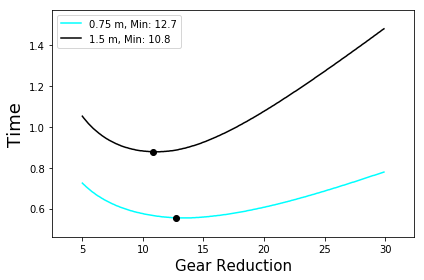

In [13]:
colors = cycle(["aqua", "black", "blue", "fuchsia", "gray", "green", "lime", "maroon", "navy", "olive", "purple", "red", "silver", "teal", "yellow"])

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range (0, travel_distances.size):
    ax.plot(ratioTests, data[i], label=str(travel_distances[i]) + " m, Min: " + str(round(minimums[0, i], 3)), color=next(colors))
    
ax.plot(minimums[0], minimums[1], "ko")
    
    
ax.set_xlabel("Gear Reduction", fontsize=15)
ax.set_ylabel("Time", fontsize=18)

ax.legend(loc="best")

ax.margins(0.1)
fig.tight_layout()

plt.show()


In [7]:
minimums   # 6 motor

array([[11.3  , 10.4  ,  9.1  ],
       [ 0.933,  1.13 ,  1.481]])

In [8]:
minimums    # 4 motor

array([[11.3  , 10.4  ,  9.1  ],
       [ 0.933,  1.13 ,  1.481]])

In [7]:
from sympy import *
init_printing(True)
t = Symbol('t')
T = Symbol('T')
c1 = Symbol('c_1')
c2 = Symbol('c_2')
integrate(c1*t*exp(c2*t),(t,0,T))

⎧             2                             
⎪            T ⋅c₁                     3    
⎪            ─────               for c₂  = 0
⎪              2                            
⎪                                           
⎨      ⎛       2        ⎞  T⋅c₂             
⎪ c₁   ⎝T⋅c₁⋅c₂  - c₁⋅c₂⎠⋅ℯ                 
⎪─── + ────────────────────────   otherwise 
⎪  2               3                        
⎪c₂              c₂                         
⎩                                           

$ (c_1/c_2**2 + (T*c_1*c_2**2 - c_1*c_2)*exp(T*c_2)/c_2**3 $

In [4]:
solve(T + exp(T), T)

[-LambertW(1)]

In [6]:
c_1 = Symbol("c_1")
c_2 = Symbol("c_2")
t = Symbol("t")
solve(-(c_1*(c_2*t - 1) - c_1*exp(t*c_2)) / (c_2**2), t)

[(1 - LambertW(-E))/c_2]